In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pandas as pd

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, Layer
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

import keras.backend as K

from vae_utils import *

Using TensorFlow backend.


# Data

In [3]:
def preprocess(data):
    x, y = data
    x = x.reshape((len(x), 784))
    x = x/255.
    #y = to_categorical(y, 10) #don't need to categorise y
    return x, y

## MNIST

In [4]:
train, test = mnist.load_data()

x_train, y_train = preprocess(train)
x_test, y_test = preprocess(test)

print(x_train.shape)

(60000, 784)


## Generated

In [5]:
mean = zeros(5)
S_gen = 1/2 * array([
    [1, 0.9, 0.8, 0.7, 0.6],
    [0, 1, 0.9, 0.8, 0.7],
    [0, 0, 1, 0.9, 0.8],
    [0, 0, 0, 1, 0.9],
    [0, 0, 0, 0, 1]
])
S_gen = S_gen + S_gen.T

x_gen = np.random.multivariate_normal(mean, S_gen, size=(60000,))

# PCA Model

## Generated

In [6]:
# get the mean & cov of our data
b = np.mean(x_gen, axis=0)
S = S_gen

In [7]:
# find the eigs and eigenvectors of the cov matrix and sort according
eigs, evecs = linalg.eig(S)

eig_pairs = list(zip(eigs, evecs.T))
eig_pairs.sort(reverse=True, key=lambda x: x[0])

In [8]:
# select the top q principle components
q = 2
d = len(eig_pairs)
N = len(x_train)

pca_pairs = eig_pairs[:q]

pca_eigs = [pca_pairs[i][0] for i in range(len(pca_pairs))]
pca_vecs = [pca_pairs[i][1] for i in range(len(pca_pairs))]

# construct W and alpha^{-1}
L_q = diag(pca_eigs)
U_q = array(pca_vecs).T

alpha = 1/(d-q) * np.sum([eig_pairs[j][0] for j in range(q+1, d)]) #technically inverse alpha

W = np.matmul(U_q, L_q - alpha * eye(q))
if q == 2:
    theta = pi/20
    R = np.array([
        [cos(theta), -sin(theta)],
        [sin(theta), cos(theta)]
    ])
    W = matmul(W, R)

# find p(z|x)
M = matmul(W.T, W) + alpha * eye(q)
p_z_x_mu = matmul(matmul(inv(M), W.T), (x_gen-b).T).T
p_z_x_sig = alpha * inv(M)

# find best q(z|x)
q_z_x_mu = matmul(matmul(inv(M), W.T), (x_gen-b).T).T
q_z_x_sig = diag(1/diag(1/alpha * M))

# find p(x)
p_x_mu = b
p_x_sig = matmul(W, W.T) + alpha * eye(d)
inv_p = inv(p_x_sig)

# find p(x|z)
p_x_z_mu = lambda z: matmul(W, z.T).T + b
p_x_z_sig = alpha * eye(d)

# calculate log p(x)
detsign, detlog = linalg.slogdet(2*pi*p_x_sig)
log_p_x = -N/2 * detlog - 1/2 * tensordot(matmul(x_gen-p_x_mu, inv_p), x_gen-p_x_mu)
log_p_x_mean = log_p_x / N

# calculate the elbo
z_samples = q_z_x_mu + random.multivariate_normal(zeros(q), q_z_x_sig, size=len(q_z_x_mu))
x_z_mu = p_x_z_mu(z_samples)

log_p = lambda x, mu, sig: -N/2 * linalg.slogdet(2*pi*sig)[1] - 1/2 * tensordot(matmul(x-mu, inv(sig)), x-mu)
log_p_x_z = log_p(x_gen, x_z_mu, p_x_z_sig)
log_p_z = log_p(z_samples, zeros(q), eye(q))
log_q_z_x = log_p(z_samples, q_z_x_mu, q_z_x_sig)

pca_elbo = log_p_x_z + log_p_z - log_q_z_x
pca_elbo_mean = pca_elbo / N

In [9]:
M

array([[ 5.28997434, -0.75540478],
       [-0.75540478,  0.64018065]])

In [12]:
matmul(matmul(R.T, linalg.matrix_power(L_q - alpha * eye(q), 2)), R) + alpha * eye(q)

array([[ 5.28997434, -0.75540478],
       [-0.75540478,  0.64018065]])

In [11]:
matmul(U_q.T, U_q)

array([[ 1.00000000e+00, -3.71367069e-17],
       [-3.71367069e-17,  1.00000000e+00]])

In [9]:
z_samples = p_z_x_mu + np.random.multivariate_normal(zeros(q), p_z_x_sig, size=len(p_z_x_mu))
x_z_gen = p_x_z_mu(z_samples)
x_pca_gen = x_z_gen.reshape(len(x_z_gen), 5)

In [10]:
p_z_x_sig

array([[0.08076496, 0.0953016 ],
       [0.0953016 , 0.66738129]])

In [11]:
q_z_x_sig

array([[0.06715596, 0.        ],
       [0.        , 0.55492665]])

In [12]:
log_p_x_mean

-6.833642729761733

In [13]:
pca_elbo_mean

-6.925963463442936

### Second Order

In [14]:
def get_pca_samples(mu, sig, n=30):
    z_samples = array([np.random.multivariate_normal(m, sig, size=(n,)) for m in mu])
    
    z_samples = np.transpose(z_samples, (1, 0, 2))

    log_p_x_zs = []

    for z_sample in z_samples:
        x_z = p_x_z_mu(z_sample)
        log_p_x_zs.append(log_p(x_gen, x_z, p_x_z_sig))

    log_p_zs = np.array([log_p(z_sample, zeros(q), eye(q)) for z_sample in z_samples])
    log_q_z_xs = np.array([log_p(z_sample, mu, sig) for z_sample in z_samples])
    
    pca_elbos = (log_p_x_zs + log_p_zs - log_q_z_xs) / N # -V(z)
    
    return pca_elbos

In [15]:
pca_elbos = get_pca_samples(p_z_x_mu, p_z_x_sig)
print('Prob: p_z_x')
print('-----------')
print('Mean: %.8f' %np.mean(pca_elbos))
print('Var: %.8f' %np.var(pca_elbos, ddof=1))

pca_elbos = get_pca_samples(q_z_x_mu, q_z_x_sig, n=500)
print('\nProb: q_z_x')
print('-----------')
print('Mean: %.8f' %np.mean(pca_elbos))
print('Var: %.8f' %(np.var(pca_elbos, ddof=1) * N))

Prob: p_z_x
-----------
Mean: -6.83364273
Var: 0.00000000

Prob: q_z_x
-----------
Mean: -6.92592989
Var: 0.15945252


In [16]:
calc_var = 1/2 * trace(linalg.matrix_power(matmul(M-diag(diag(M)), diag(1/diag(M))), 2))
calc_var

0.16850133572559414

In [17]:
np.mean(pca_elbos) + 1/2 * calc_var

-6.841679217915284

In [18]:
np.mean(pca_elbos) + 1/2 * np.var(pca_elbos, ddof=1) * N

-6.846203627913299

## MNIST

In [19]:
# get the mean & cov of our data
b = np.mean(x_train, axis=0)

# S = 0
# for x in x_train:
#     S+= np.outer(x-b, x-b)
# S /= len(x_train)
# np.save('./S.npy', S)

# np.save('./S.npy', S)
S = np.load('./S.npy')

In [20]:
# find the eigs and eigenvectors of the cov matrix and sort according
eigs, evecs = linalg.eig(S)

eig_pairs = list(zip(eigs, evecs.T))
eig_pairs.sort(reverse=True, key=lambda x: x[0])

In [21]:
# select the top q principle components
q = 2
d = len(eig_pairs)
N = len(x_train)

pca_pairs = eig_pairs[:q]

pca_eigs = [pca_pairs[i][0] for i in range(len(pca_pairs))]
pca_vecs = [pca_pairs[i][1] for i in range(len(pca_pairs))]

# construct W and alpha^{-1}
L_q = diag(pca_eigs)
U_q = array(pca_vecs).T

alpha = 1/(d-q) * np.sum([eig_pairs[j][0] for j in range(q+1, d)]) #technically inverse alpha

W = np.matmul(U_q, L_q - alpha * eye(q))
if q == 2:
    theta = pi/4
    R = np.array([
        [cos(theta), -sin(theta)],
        [sin(theta), cos(theta)]
    ])
    W = matmul(W, R)
    

# find p(z|x)
M = matmul(W.T, W) + alpha * eye(q)
p_z_x_mu = matmul(matmul(inv(M), W.T), (x_train-b).T).T
p_z_x_sig = alpha * inv(M)

# find best q(z|x)
q_z_x_mu = matmul(matmul(inv(M), W.T), (x_train-b).T).T
q_z_x_sig = diag(1/diag(1/alpha * M))

# find p(x)
p_x_mu = b
p_x_sig = matmul(W, W.T) + alpha * eye(d)
inv_p = inv(p_x_sig)

# find p(x|z)
p_x_z_mu = lambda z: matmul(W, z.T).T + b
p_x_z_sig = alpha * eye(d)

# calculate log p(x)
detsign, detlog = linalg.slogdet(2*pi*p_x_sig)
log_p_x = -N/2 * detlog - 1/2 * tensordot(matmul(x_train-p_x_mu, inv_p), x_train-p_x_mu)
log_p_x_mean = log_p_x / N

# calculate the elbo
z_samples = array([random.multivariate_normal(mu, q_z_x_sig) for mu in q_z_x_mu])
x_z_mu = p_x_z_mu(z_samples)

log_p = lambda x, mu, sig: -N/2 * linalg.slogdet(2*pi*sig)[1] - 1/2 * tensordot(matmul(x-mu, inv(sig)), x-mu)
log_p_x_z = log_p(x_train, x_z_mu, p_x_z_sig)
log_p_z = log_p(z_samples, zeros(q), eye(q))
log_q_z_x = log_p(z_samples, q_z_x_mu, q_z_x_sig)

pca_elbo = log_p_x_z + log_p_z - log_q_z_x
pca_elbo_mean = pca_elbo / N

In [22]:
z_samples = array([np.random.multivariate_normal(mu, p_z_x_sig) for mu in p_z_x_mu])
x_z = p_x_z_mu(z_samples)
x_pca = x_z.reshape(len(x_z), 28, 28)

In [23]:
log_p_x_mean

10.545761523876463

In [24]:
pca_elbo_mean

10.498086272295428

In [25]:
p_z_x_sig

array([[0.0029108 , 0.00089029],
       [0.00089029, 0.0029108 ]])

In [26]:
q_z_x_sig

array([[0.00263849, 0.        ],
       [0.        , 0.00263849]])

### 2nd Order Calculations

In [27]:
def get_pca_samples(mu, sig, n=30):
    z_samples = array([np.random.multivariate_normal(m, sig, size=(n,)) for m in mu])
    
    z_samples = np.transpose(z_samples, (1, 0, 2))

    log_p_x_zs = []

    for z_sample in z_samples:
        x_z = p_x_z_mu(z_sample)
        log_p_x_zs.append(log_p(x_train, x_z, p_x_z_sig))

    log_p_zs = np.array([log_p(z_sample, zeros(q), eye(q)) for z_sample in z_samples])
    log_q_z_xs = np.array([log_p(z_sample, mu, sig) for z_sample in z_samples])
    
    pca_elbos = (log_p_x_zs + log_p_zs - log_q_z_xs) / N # -V(z)
    
    return pca_elbos

In [35]:
#pca_elbos = get_pca_samples(p_z_x_mu, p_z_x_sig)
print('Prob: p_z_x')
print('-----------')
print('Mean: %.8f' %log_p_x_mean)
print('Var: %.8f' %0.0)

pca_elbos = get_pca_samples(q_z_x_mu, q_z_x_sig)
print('\nProb: q_z_x')
print('-----------')
print('Mean: %.8f' %np.mean(pca_elbos))
print('Var: %.8f' %(np.var(pca_elbos, ddof=1) * N))

Prob: p_z_x
-----------
Mean: 10.54576152
Var: 0.00000000

Prob: q_z_x
-----------
Mean: 10.49666488
Var: 0.12616527


In [29]:
calc_var = 1/2 * trace(linalg.matrix_power(matmul(M-diag(diag(M)), diag(1/diag(M))), 2))
calc_var

0.09354949547635669

In [30]:
np.mean(pca_elbos) + 1/2 * calc_var

10.5434790402116

In [31]:
# make a bad encoder
bad_q_z_x_sig = eye(q)
bad_q_z_x_mu = np.random.multivariate_normal(zeros(q), bad_q_z_x_sig, size=len(q_z_x_mu))

pca_elbos = get_pca_samples(bad_q_z_x_mu, bad_q_z_x_sig)
print('Prob: bad_q_z_x')
print('-----------')
print('Mean: %.8f' %np.mean(pca_elbos))
print('Std: %.8f' %(np.var(pca_elbos, ddof=1) * N))

Prob: bad_q_z_x
-----------
Mean: -825.16905929
Std: 9.79993117


### Visualise

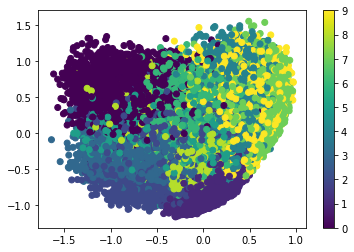

In [32]:
if q == 2:
    figure()
    m = p_z_x_mu
    scatter(m[:, 0], m[:, 1], c=y_train)
    colorbar()

# VAE Model

In [33]:
# VAE model from "Auto Encoding Variation Bayes": https://arxiv.org/pdf/1312.6114.pdf
# encoder model is modelled by a gaussian, producing the latent
# variables mean and its log standard deviation

def gauss_model(latent_dim, hidden_dim=200):
    # encoder shared layers
    enc_hid = Dense(hidden_dim, activation='relu', name='enc_hidden')
    #z_mean = Dense(latent_dim, name='latent_mean')
    #log_z_var = Dense(latent_dim, name='log_latent_var')
    enc_layer = Encoder(latent_dim, name='enc_mean')
    
    # decoder shared layers
    dec_hid = Dense(hidden_dim, activation='relu', name='dec_hidden')
    #dec_mean = Dense(28*28, name='dec_mean')
    #log_dec_var = Dense(1, name='log_dec_var')
    dec_layer = Decoder(28*28, name='dec_mean')
    
    # encoder model
    enc_in = Input(shape=(784,), name='enc_input')
    #y = enc_hid(enc_in)
    y = enc_in
    #y_1 = z_mean(y)
    #y_2 = log_z_var(y)
    y_1, y_2 = enc_layer(y)
    enc_model = Model(enc_in, y_1, name='encoder_model')
    
    # decoder model
    dec_in = Input(shape=(latent_dim,), name='dec_in')
    #y = dec_hid(dec_in)
    y = dec_in
    #y_1 = dec_mean(y)
    #y_2 = log_dec_var(y)
    y_1, y_2 = dec_layer(y)
    dec_model = Model(dec_in, y_1, name='decoder model')
    
    # encoder - decoder model
    y = enc_in
    #y = enc_hid(y)
    #z_mean = z_mean(y)
    #log_z_var = log_z_var(y)
    z_mean, log_z_var = enc_layer(y)
    y = Sampler(always_sample=True, name='z_sampler')([z_mean, log_z_var])
    #y = dec_hid(y)
    #dec_mean = dec_mean(y)
    #log_dec_var = log_dec_var(y)
    dec_mean, log_dec_var = dec_layer(y)
    #y = Sampler(name='out_sampler')([dec_mean, log_dec_var])
    enc_dec_model = Model(enc_in, dec_mean, name='encdec model')
    
    return (enc_model, dec_model, enc_dec_model), (z_mean, log_z_var), (dec_mean, log_dec_var)

# we need a layer that samples a latent variable given a mean and standard deviation

class Sampler(Layer):
    
    def __init__(self, always_sample=False, **kwargs):
        self.always_sample = always_sample
        super(Sampler, self).__init__(**kwargs)
    
    def call(self, x, training=None):
        assert isinstance(x, list)
        z_mean, log_z_var = x
        z_std = K.exp(log_z_var/2)
        
        # sample epsilon from N(0, stddev)
        shape = K.shape(z_mean)
        epsilon = K.random_normal(shape, mean=0, stddev=1)
        z_sample = z_mean + z_std * epsilon
        
        if self.always_sample:
            return z_sample
        else:
            return K.in_train_phase(z_sample, z_mean, training=training)
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return input_shape[0]
    
    
# to properly make a global decoder variance, we need a decoder layer


class Decoder(Dense):
    
    #def __init__(self, units, **kwargs):
    #    super(Decoder, self).__init__(units, **kwargs)
    
    def build(self, input_shape):
        self.log_dec_var = self.add_weight(
            name='log_dec_var',
            shape=(1,),
            initializer='zeros'
        )
        super(Decoder, self).build(input_shape)
        
    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
            
        output = [output, self.log_dec_var]
        
        return output
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return [tuple(output_shape), (1,)]
    
    
# to properly make a global latent variance, we need an encoder layer    
    
    
class Encoder(Dense):
    
    def __init__(self, units, always_sample=False, **kwargs):
        self.always_sample = False
        super(Encoder, self).__init__(units, **kwargs)
        
    def build(self, input_shape):
        assert len(input_shape) >= 2
        
        self.log_z_mean = self.add_weight(
            name='log_z_mean',
            shape=(self.units,),
            initializer='zeros'
        )
        super(Encoder, self).build(input_shape)
        
    def call(self, inputs):
        z_mean = K.dot(inputs, self.kernel)
        if self.use_bias:
            z_mean = K.bias_add(z_mean, self.bias, data_format='channels_last')
        if self.activation is not None:
            z_mean = self.activation(z_mean)
            
        output = [z_mean, self.log_z_mean]
        
        return output
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return [tuple(output_shape), (self.units,)]

In [93]:
latent_dim = 2
hidden_dim = 200

models, latent_vars, dec_outs = gauss_model(latent_dim, hidden_dim)
enc_model, dec_model, enc_dec_model = models
z_mean, log_z_var = latent_vars
dec_mean, log_dec_var = dec_outs

# elbo loss
def gauss_loss(y_true, y_pred):
    kl_loss = - 1/2 * K.sum(1 + log_z_var - K.square(z_mean) - K.exp(log_z_var), axis=-1)
    im_loss = (
        1/2 * 784 * (K.log(2*pi) + log_dec_var)
        + 1/2 * K.batch_dot(y_true - dec_mean, (y_true-dec_mean) * K.exp(-log_dec_var), axes=-1)
    )[:, 0]
    return kl_loss + im_loss

enc_dec_model.compile(optimizer='adam', loss=gauss_loss)

# train and save the model
epochs = 50
batch_size = 256

dec_path = './dec_model_%d_dim.weights' %latent_dim
weights_path = './enc_dec_model_%d_dim.weights' %latent_dim
loss_path = './training_loss_%d_dim.png' %latent_dim

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

history = enc_dec_model.fit(
    x=x_train, y=x_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, x_test),
    callbacks=[reduce_lr]
)

# if not os.path.exists(weights_path):
#     # training
#     history = enc_dec_model.fit(
#         x=x_train, y=[x_train, x_train],
#         batch_size=batch_size,
#         epochs=epochs,
#         validation_data=(x_test, [x_test, x_test])
#     )
#     # enc_dec_model represents the whole dec_model as a single layer
#     # so we have to save the decoder weights seperately
#     dec_model.save_weights(dec_path) # hacky fix for decoder weights
#     enc_dec_model.save_weights(weights_path)
#     # plotting
#     plot([-x for x in history.history['loss']])
#     xlabel('Epoch')
#     ylabel('ELBO')
#     ylim(-200, -90)
#     gcf().savefig(loss_path, bbox_inches='tight')
#     print('Model Saved')
# else:
#     dec_model.load_weights(dec_path, by_name=True)
#     enc_model.load_weights(weights_path, by_name=True)
#     enc_dec_model.load_weights(weights_path, by_name=True)
#     print('Model Loaded')


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 53us/step - loss: 710.0512 - val_loss: 662.2325
Epoch 2/50
60000/60000 [==============================] - 2s 41us/step - loss: 619.3575 - val_loss: 576.9084
Epoch 3/50
60000/60000 [==============================] - 2s 41us/step - loss: 535.8346 - val_loss: 495.0906
Epoch 4/50
60000/60000 [==============================] - 3s 42us/step - loss: 455.7912 - val_loss: 416.9718
Epoch 5/50
60000/60000 [==============================] - 3s 49us/step - loss: 379.8560 - val_loss: 343.3566
Epoch 6/50
60000/60000 [==============================] - 3s 48us/step - loss: 308.8354 - val_loss: 274.5359- ETA: 
Epoch 7/50
60000/60000 [==============================] - 3s 45us/step - loss: 243.4017 - val_loss: 212.2344
Epoch 8/50
60000/60000 [==============================] - 3s 46us/step - loss: 184.7567 - val_loss: 157.1191
Epoch 9/50
60000/60000 [==============================] - 3s 47us/step 

In [94]:
x_pred = enc_dec_model.predict(x_train, batch_size=2000)
z_mean = enc_model.predict(x_train, batch_size=2000)
log_z_var = K.eval(log_z_var)
z_samples = z_mean + np.random.normal(loc=0, scale=1, size=z_mean.shape) * np.exp(log_z_var/2)
dec_mean= dec_model.predict(z_samples, batch_size=2000)
log_dec_var = K.eval(log_dec_var)

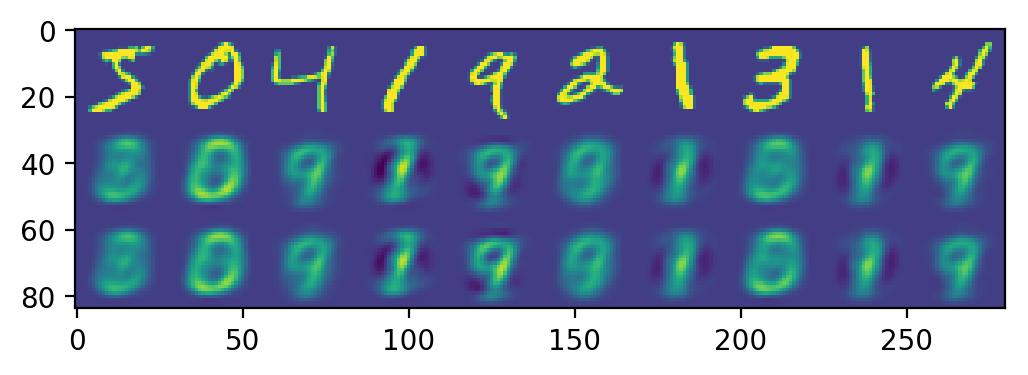

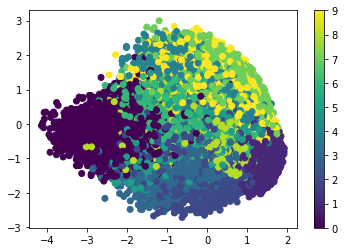

In [95]:
x_pred = x_pred.reshape((len(x_pred), 28, 28))
xs = x_train.reshape((len(x_train), 28, 28))
image = np.concatenate([np.concatenate(x[:10], axis=1) for x in [xs, x_pred, x_pca]], axis=0)

figure(dpi=200)
imshow(image)
plt.show()

if latent_dim == 2:
    figure()
    scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
    colorbar()
    plt.show()

In [96]:
x = x_train - dec_mean

# calculate im_loss

def elbo_loss(x):
    im_loss = (
        1/2 * 784 * (np.log(2*pi) + log_dec_var)
        + 1/2 * array([np.dot(x[i], x[i] * np.exp(-log_dec_var)) for i in range(len(x))])
    )

    # calculate kl_loss
    kl_loss = - 1/2 * np.sum(1 + np.mean(log_z_var, axis=0) - np.square(z_mean) - np.exp(np.mean(log_z_var, axis=0)), axis=-1)
    
    return im_loss + kl_loss

# elbo
loss = elbo_loss(x)
-np.mean(loss),  log_p_x_mean

(12.422600870384048, 10.545761523876463)

## 2nd order calculation

In [97]:
n = 50
z_samples = array([np.random.multivariate_normal(m, diag(np.exp(log_z_var)), size=(n,)) for m in z_mean])
z_samples = np.transpose(z_samples, (1, 0, 2))

losses = []

for z_sample in z_samples:
    mean_sample = dec_model.predict(z_sample, batch_size=2000)
    x = x_train - mean_sample
    losses.append(elbo_loss(x))
    
losses = np.array(losses)

In [98]:
np.mean(np.var(losses, axis=0))

0.9774412738466448

In [100]:
np.mean(losses) + 1/2 * np.mean(np.var(losses, axis=0))

-11.934600415733291

## Comparisons to pca model

In [ ]:
exp(log_dec_var)

In [134]:
alpha

0.05193640031743779

In [135]:
(log_p_z - log_q_z_x)/ N

-5.125344667008298

In [136]:
q_z_x_sig

array([[0.00202051, 0.        ],
       [0.        , 0.00380109]])

In [137]:
np.exp(log_z_var)

array([0.01504741, 0.01231423], dtype=float32)

## Model weights

In [204]:
# presume p(z|x) = N(z; W_z_x x + b_z_x, var_z_x)
W_z_x, b_z_x = enc_dec_model.get_layer('enc_mean').weights[1:]

W_z_x = K.eval(W_z_x)
b_z_x = K.eval(b_z_x)

W_z_x_pca = matmul(inv(M), W.T).T
b_z_x_pca = matmul(matmul(inv(M), W.T), -b.T).T

In [205]:
theta = arccos(b_z_x_pca.dot(b_z_x) / (norm(b_z_x_pca) * norm(b_z_x)))
rr = np.array([
    [cos(theta), -sin(theta)],
    [sin(theta), cos(theta)]
])

In [206]:
matmul(W_z_x, rr)

array([[-5.92349658e-02,  4.87118260e-02],
       [ 7.45791937e-02,  4.60128617e-02],
       [-1.12713932e-02,  1.86348452e-02],
       ...,
       [-5.25294029e-02,  4.92478029e-02],
       [-3.84848534e-02,  3.48137442e-05],
       [ 1.90516016e-02, -1.07170459e-02]])

In [207]:
thetas = []

for i in range(len(W_z_x)):
    theta = arccos(W_z_x_pca[i].dot(W_z_x[i]) / (norm(W_z_x_pca[i]) * norm(W_z_x[i]))) * 180 / pi
    thetas.append(theta)

C:\Users\User\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [208]:
thetas

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 4.930231816317878,
 120.90041144752153,
 46.93100071790819,
 152.7733558983198,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 25.329609995352715,
 97.24100692173336,
 125.77949265650889,
 162.39522477590933,
 178.82248452251412,
 12.482562631531438,
 166.68377630274318,
 16.15848729466222,
 37.243545246352475,
 93.7016408105711,
 177.1599734542199,
 26.450408299280692,
 57.065995144092575,
 167.10393472724056,
 24.76198225199711,
 106.0078555825837,
 27.093571425621928,
 139.58453254149327,
 38.83048583245509,
 142.35210770957505,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 87.38210104155372,
 96.36701179642732,
 93.95075662700633,
 97.25920797283389,
 145.37176311491444,
 15.045623293127653,
 4.248229670346425,
 137.72732201856664,
 90.75128676084044,
 92.67881638336517,
 153.78500080660373,
 128.5443775543629,
 97.32370952764136,
 127.43433014582051,
 72.46775951425059